In [17]:
!pip install mne


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.signal import butter, filtfilt, iirnotch, resample_poly

# Paths
data_dir = os.getcwd()
subject_info_path = os.path.join(data_dir, "subject-info.csv")

# Load subject metadata
subject_info = pd.read_csv(subject_info_path)
all_data = []

# Define filter functions
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

def notch_filter(data, notch_freq=50.0, fs=500, quality=30.0):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, quality)
    return filtfilt(b, a, data, axis=1)

# Main loop: subject & session
for subject in subject_info["Subject"]:
    for session in ["_1", "_2"]:
        file_path = os.path.join(data_dir, f"{subject}{session}.edf")
        if not os.path.exists(file_path):
            continue

        # Load raw EEG
        raw = mne.io.read_raw_edf(file_path, preload=True)
        raw_data, times = raw[:]
        channel_names = raw.ch_names

        # Apply filters
        fs = int(raw.info['sfreq'])  # Sampling rate (should be 500)
        filtered_data = notch_filter(raw_data, fs=fs)               # Optional: remove 50 Hz noise
        filtered_data = bandpass_filter(filtered_data, 1.0, 64.0, fs=fs)  # Apply bandpass

        # Downsample to 128 Hz
        downsampled_data = resample_poly(filtered_data, up=128, down=fs, axis=1)
        downsampled_times = np.arange(0, downsampled_data.shape[1]) / 128.0  # in seconds

        # Make DataFrame
        eeg_df = pd.DataFrame(downsampled_data.T, columns=channel_names)
        eeg_df["Time"] = downsampled_times

        # Add subject metadata
        metadata = subject_info[subject_info["Subject"] == subject].iloc[0]
        for col in subject_info.columns:
            if col != "Number of subtractions":  # Skip unwanted column
                eeg_df[col] = metadata[col]

        # Add session label
        eeg_df["Session"] = "Background" if session == "_1" else "Task"

        all_data.append(eeg_df)

# Combine all data
eeg_dataset = pd.concat(all_data, ignore_index=True)

# Function to downsample Background session to max 10,000 rows per subject
def downsample_background(df, max_samples=10000):
    reduced_list = []
    for subject, group in df.groupby("Subject"):
        # Separate Background and Task sessions
        bg_data = group[group["Session"] == "Background"]
        task_data = group[group["Session"] == "Task"]

        # Downsample Background if needed
        if len(bg_data) > max_samples:
            bg_data = bg_data.sample(n=max_samples, random_state=42)

        # Combine again
        reduced_list.append(pd.concat([bg_data, task_data], ignore_index=True))

    return pd.concat(reduced_list, ignore_index=True)

# Apply downsampling
eeg_dataset_reduced = downsample_background(eeg_dataset, max_samples=10000)

# Train/Test split on the reduced dataset
train_dataset = eeg_dataset_reduced[~eeg_dataset_reduced["Subject"].isin(["Subject34", "Subject35"])]
test_dataset = eeg_dataset_reduced[eeg_dataset_reduced["Subject"].isin(["Subject34", "Subject35"])]

# Save datasets
train_path = os.path.join(data_dir, "eeg_train_data.csv")
test_path = os.path.join(data_dir, "eeg_test_data.csv")
train_dataset.to_csv(train_path, index=False)
test_dataset.to_csv(test_path, index=False)

# Summary prints
print("Training Data:")
print(train_dataset.info())
print(train_dataset.head())

print("\nTesting Data:")
print(test_dataset.info())
print(test_dataset.head())


Extracting EDF parameters from c:\Users\Research PC\Desktop\ML\EEG\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from c:\Users\Research PC\Desktop\ML\EEG\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from c:\Users\Research PC\Desktop\ML\EEG\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from c:\Users\Research PC\Desktop\ML\EEG\Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from c:\Users\Research PC\Desktop\ML\EEG\Subject02_1.edf...
EDF file detec

In [19]:
session_counts_reduced = eeg_dataset_reduced.groupby(["Subject", "Session"]).size().unstack(fill_value=0)
print("\nReduced Number of Datapoints per Session per User:")
print(session_counts_reduced)


Reduced Number of Datapoints per Session per User:
Session    Background  Task
Subject                    
Subject00       10000  7936
Subject01       10000  7936
Subject02       10000  7936
Subject03       10000  7936
Subject04       10000  7936
Subject05       10000  7936
Subject06       10000  7936
Subject07       10000  7936
Subject08       10000  7936
Subject09       10000  7936
Subject10       10000  7936
Subject11       10000  7936
Subject12       10000  7936
Subject13       10000  7936
Subject14       10000  7936
Subject15       10000  7936
Subject16       10000  7936
Subject17       10000  7936
Subject18       10000  7936
Subject19       10000  7936
Subject20       10000  7936
Subject21       10000  7936
Subject22       10000  7936
Subject23       10000  7936
Subject24       10000  7936
Subject25       10000  7936
Subject26       10000  7936
Subject27       10000  7936
Subject28       10000  7936
Subject29       10000  7936
Subject30       10000  7936
Subject31       10000  7

In [20]:
train_dataset.head()

,EEG Fp1,EEG Fp2,EEG F3,EEG F4,EEG F7,EEG F8,EEG T3,EEG T4,EEG C3,EEG C4,...,EEG Pz,EEG A2-A1,ECG ECG,Time,Subject,Age,Gender,Recording year,Count quality,Session
0,6.021771e-07,0.000004,0.000002,0.000003,7.667742e-07,-0.000003,0.000009,8.405889e-06,0.000010,0.000005,...,1.284127e-05,5.334628e-07,-0.000012,70.750000,Subject00,21,F,2011,0,Background
1,6.355826e-06,0.000004,0.000009,0.000002,1.795158e-05,-0.000004,0.000009,5.241469e-06,0.000006,0.000006,...,1.185839e-05,-2.206565e-06,-0.000087,160.585938,Subject00,21,F,2011,0,Background
2,-9.489405e-07,-0.000003,-0.000002,-0.000003,-3.634014e-06,-0.000011,0.000007,-7.469972e-06,0.000004,-0.000003,...,3.244741e-06,-3.598585e-06,-0.000002,142.906250,Subject00,21,F,2011,0,Background
3,7.436416e-07,-0.000005,0.000004,-0.000005,4.611377e-06,-0.000007,0.000015,7.446048e-08,0.000007,0.000001,...,-1.177307e-06,-1.856206e-06,-0.000033,26.507812,Subject00,21,F,2011,0,Background
4,6.405549e-07,-0.000002,0.000003,-0.000004,5.825046e-06,0.000008,-0.000021,-1.618060e-06,-0.000007,-0.000002,...,-4.057560e-07,1.648839e-06,-0.000079,139.070312,Subject00,21,F,2011,0,Background


In [21]:
eeg_channels = [
    'EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8',
    'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6',
    'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz'
]

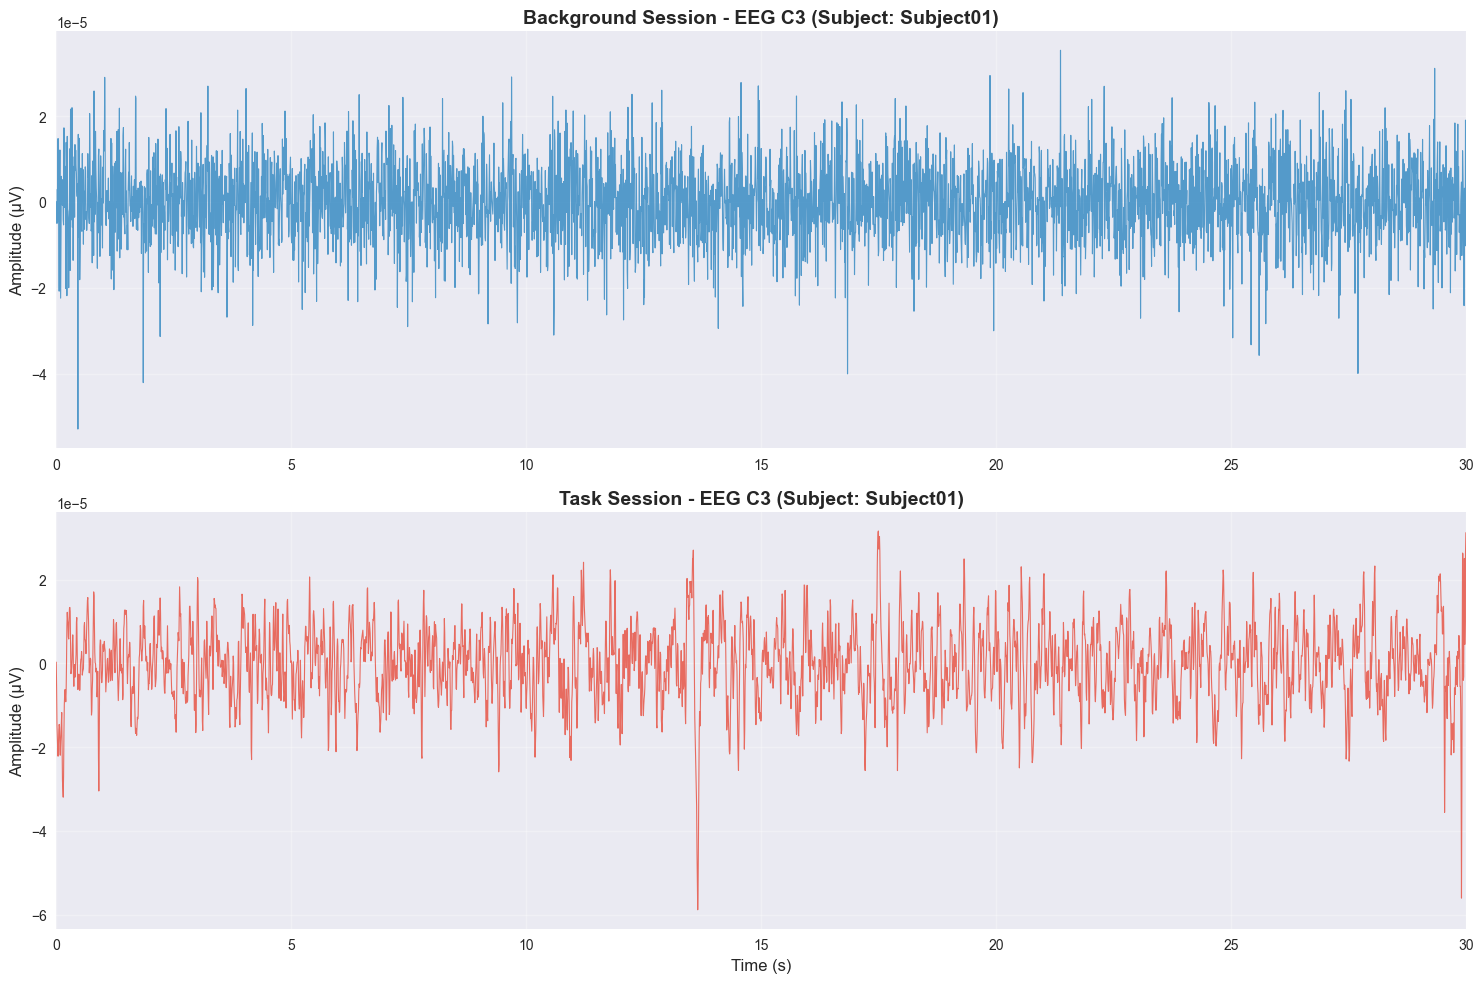

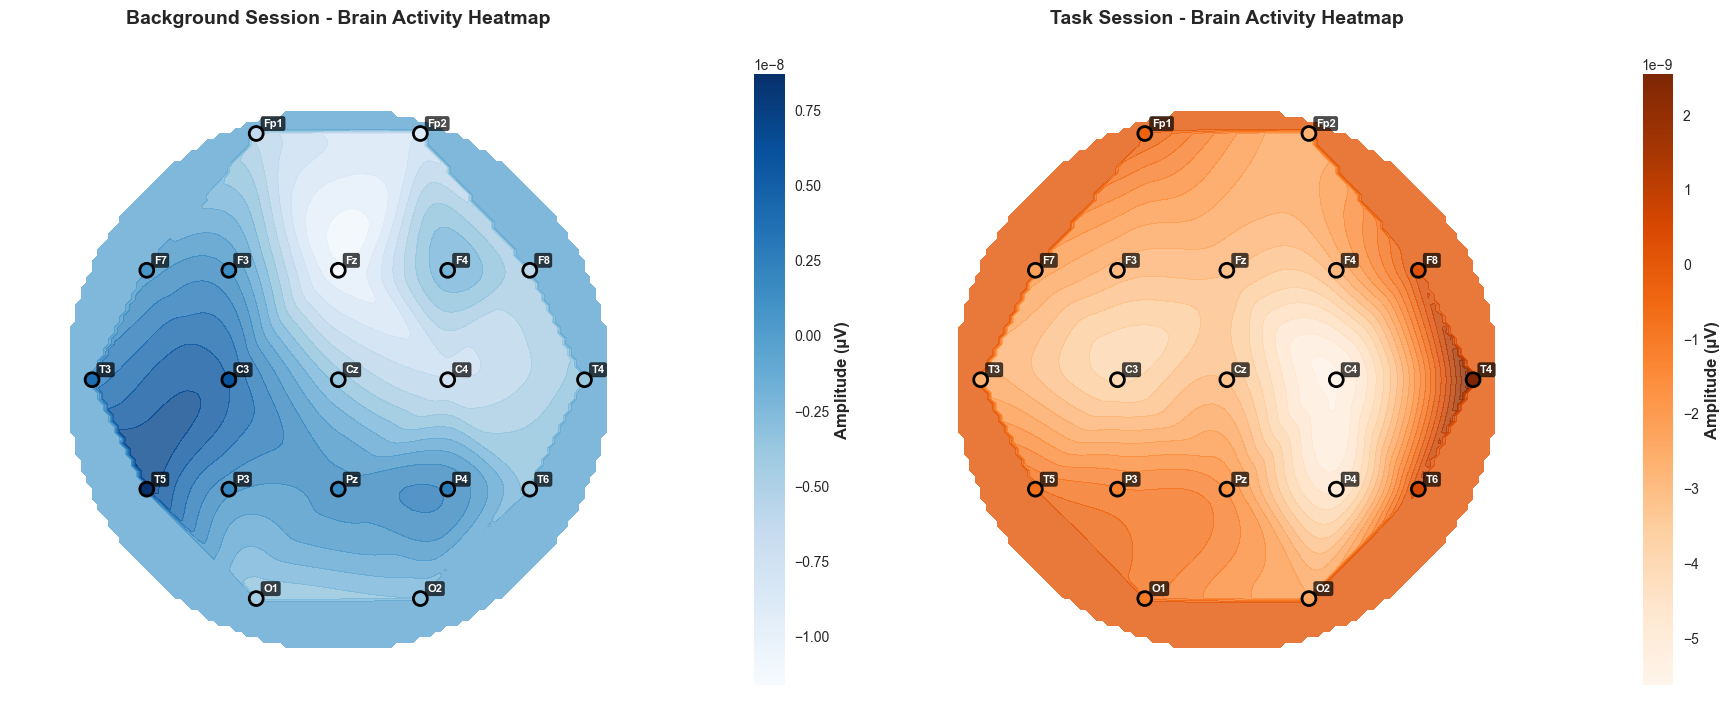

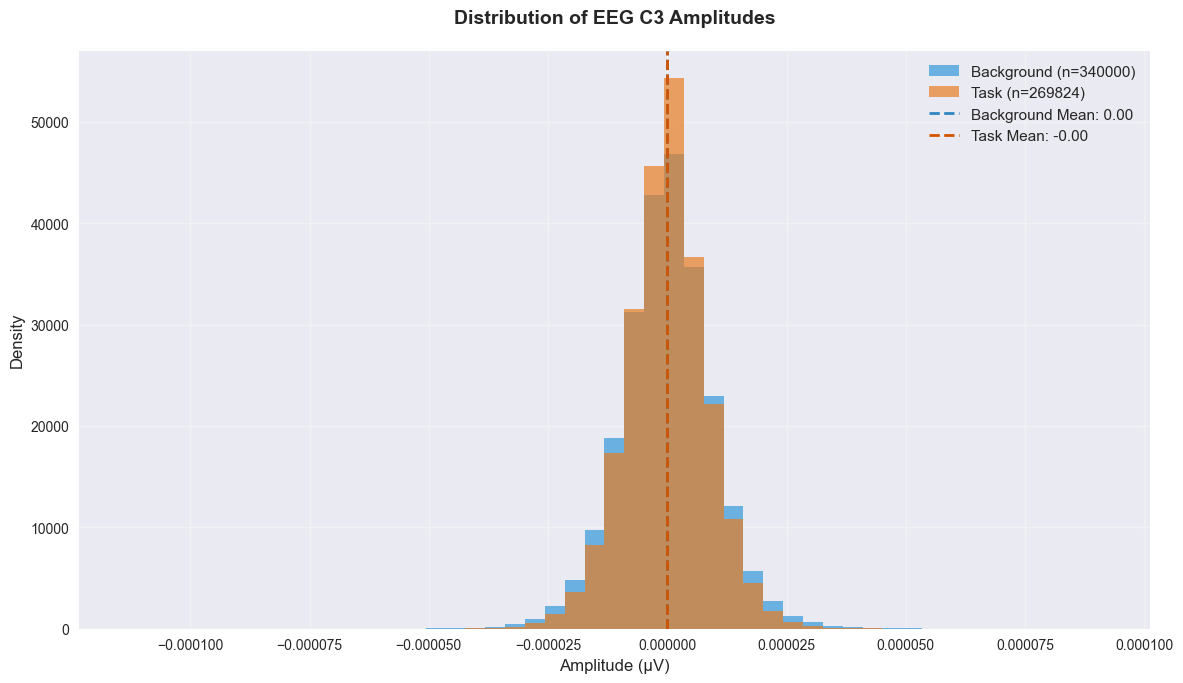

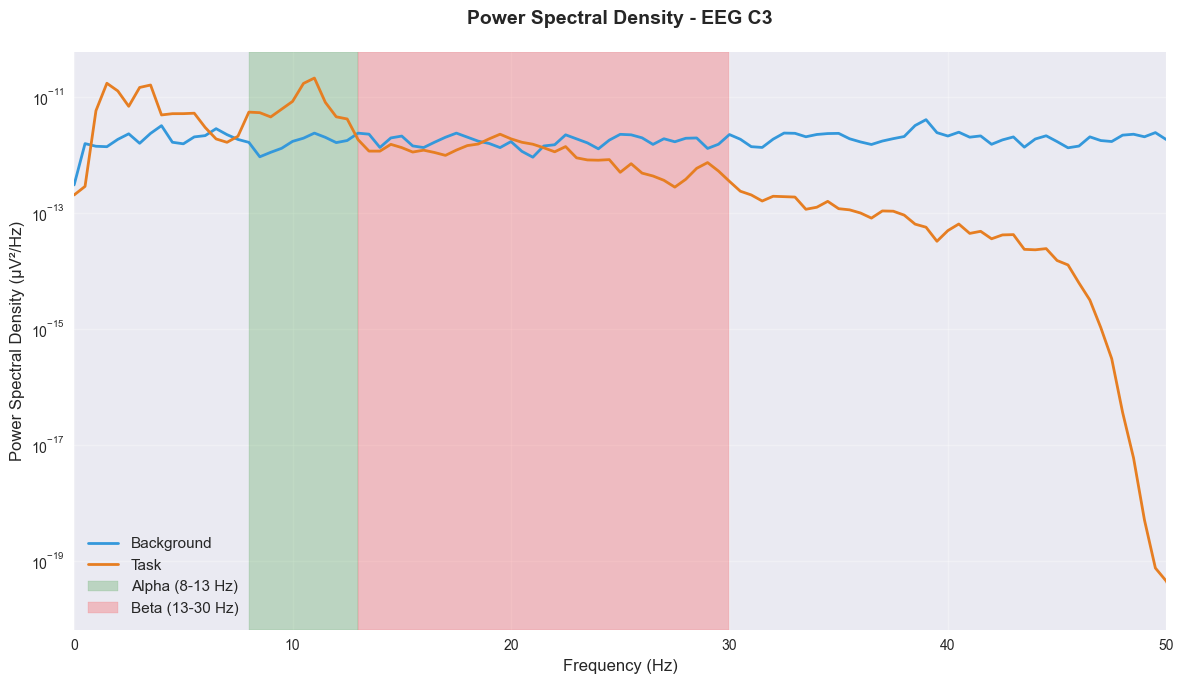

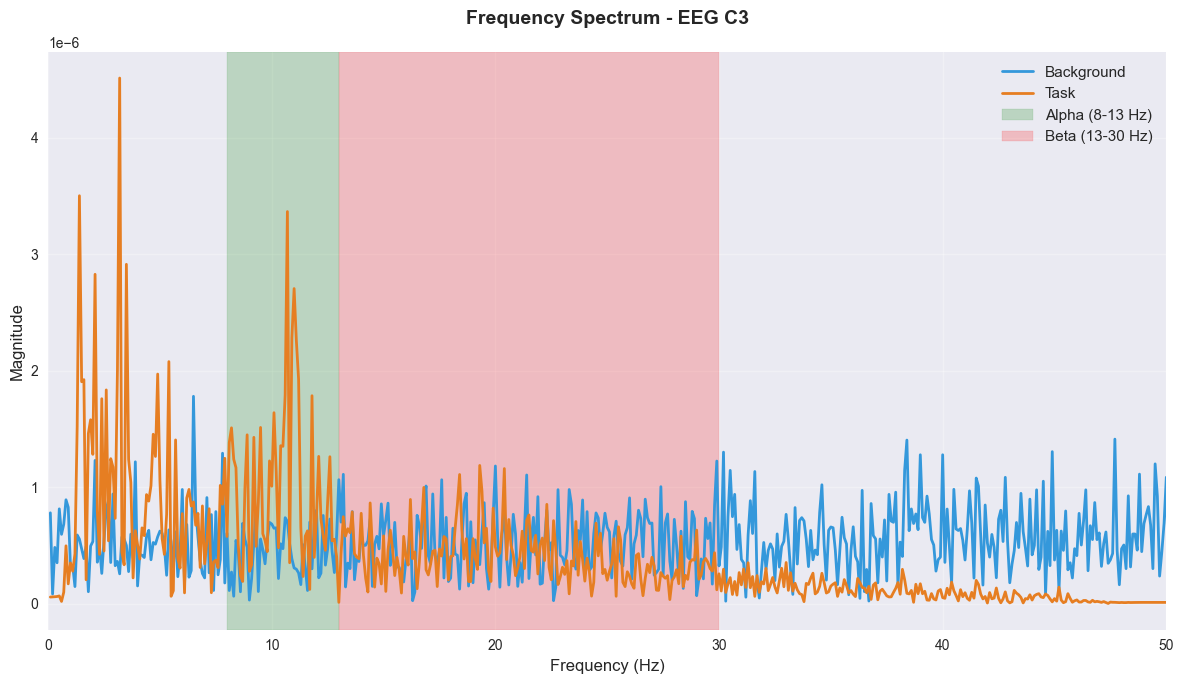

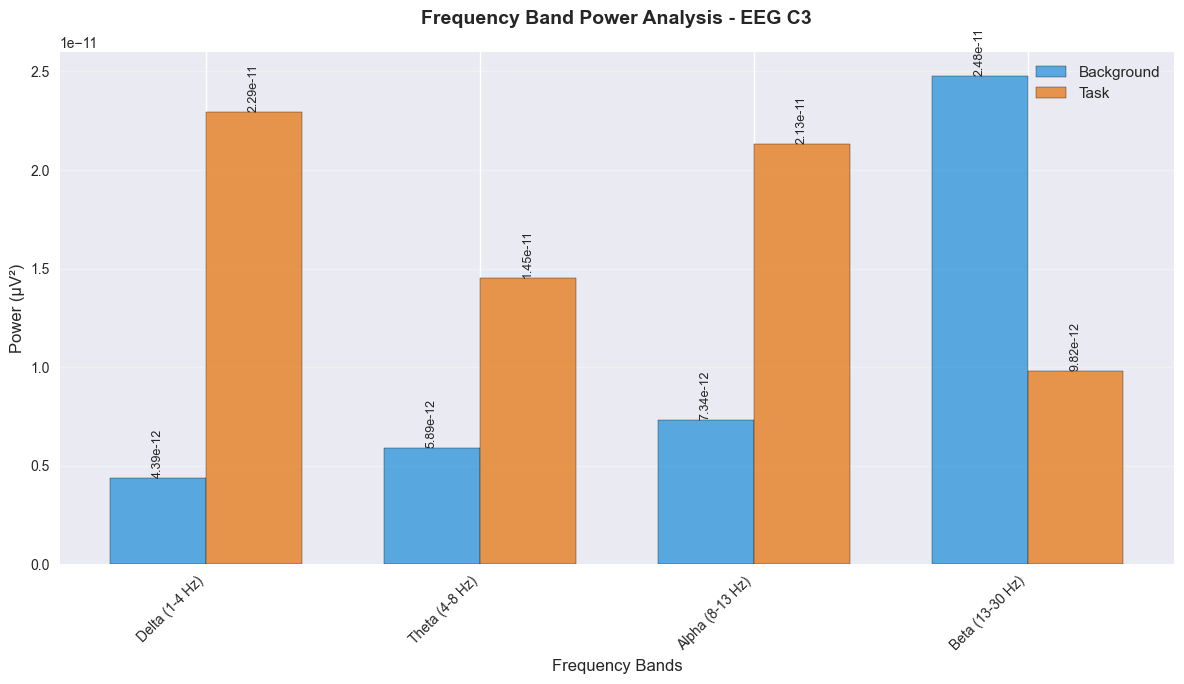

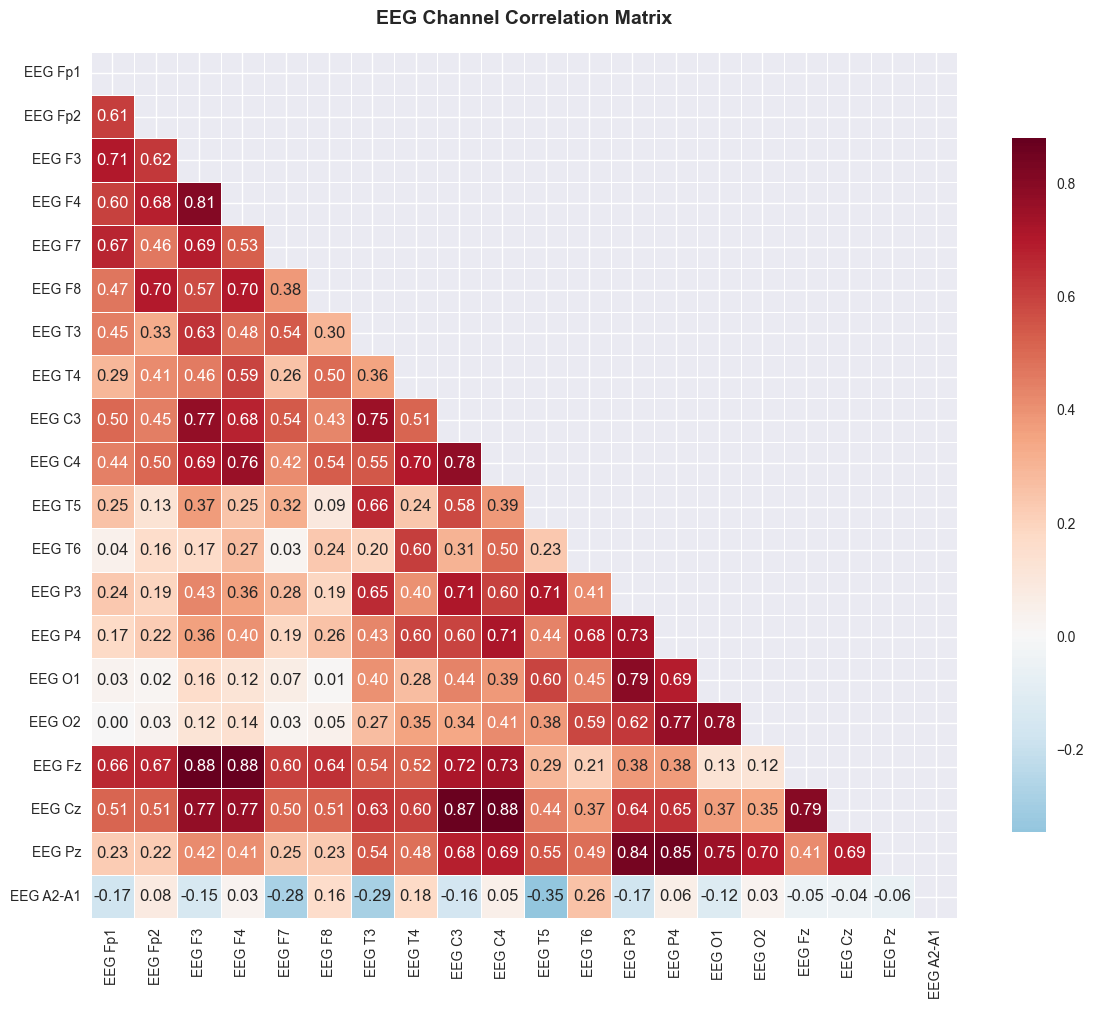

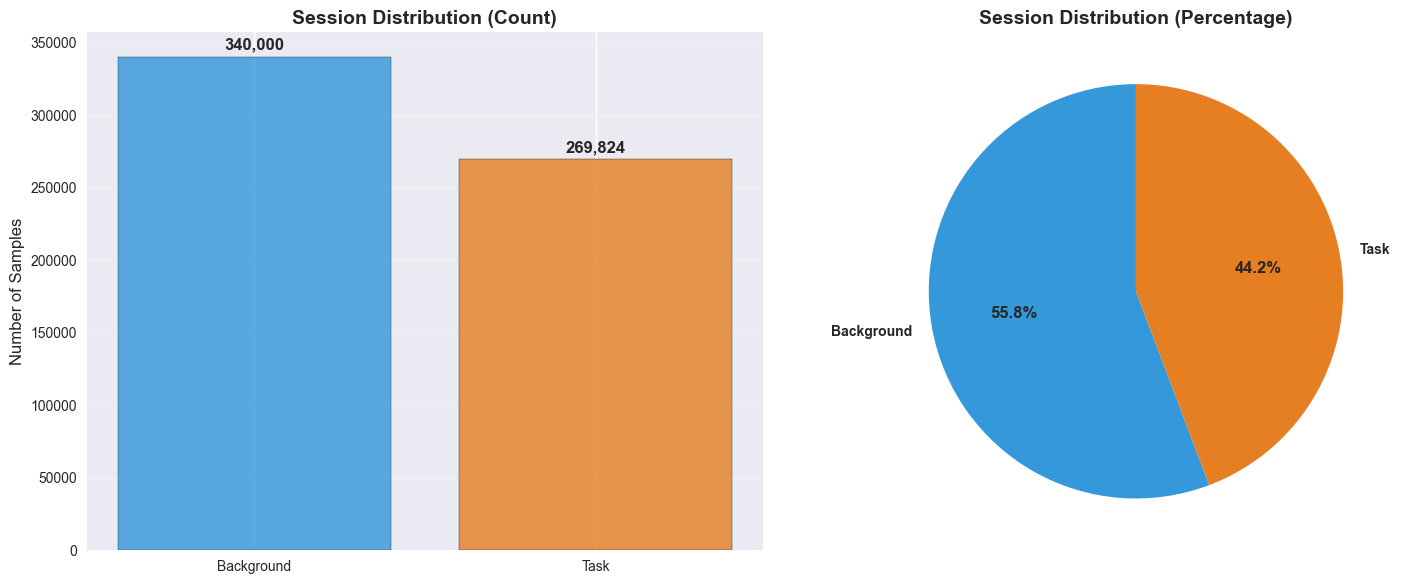

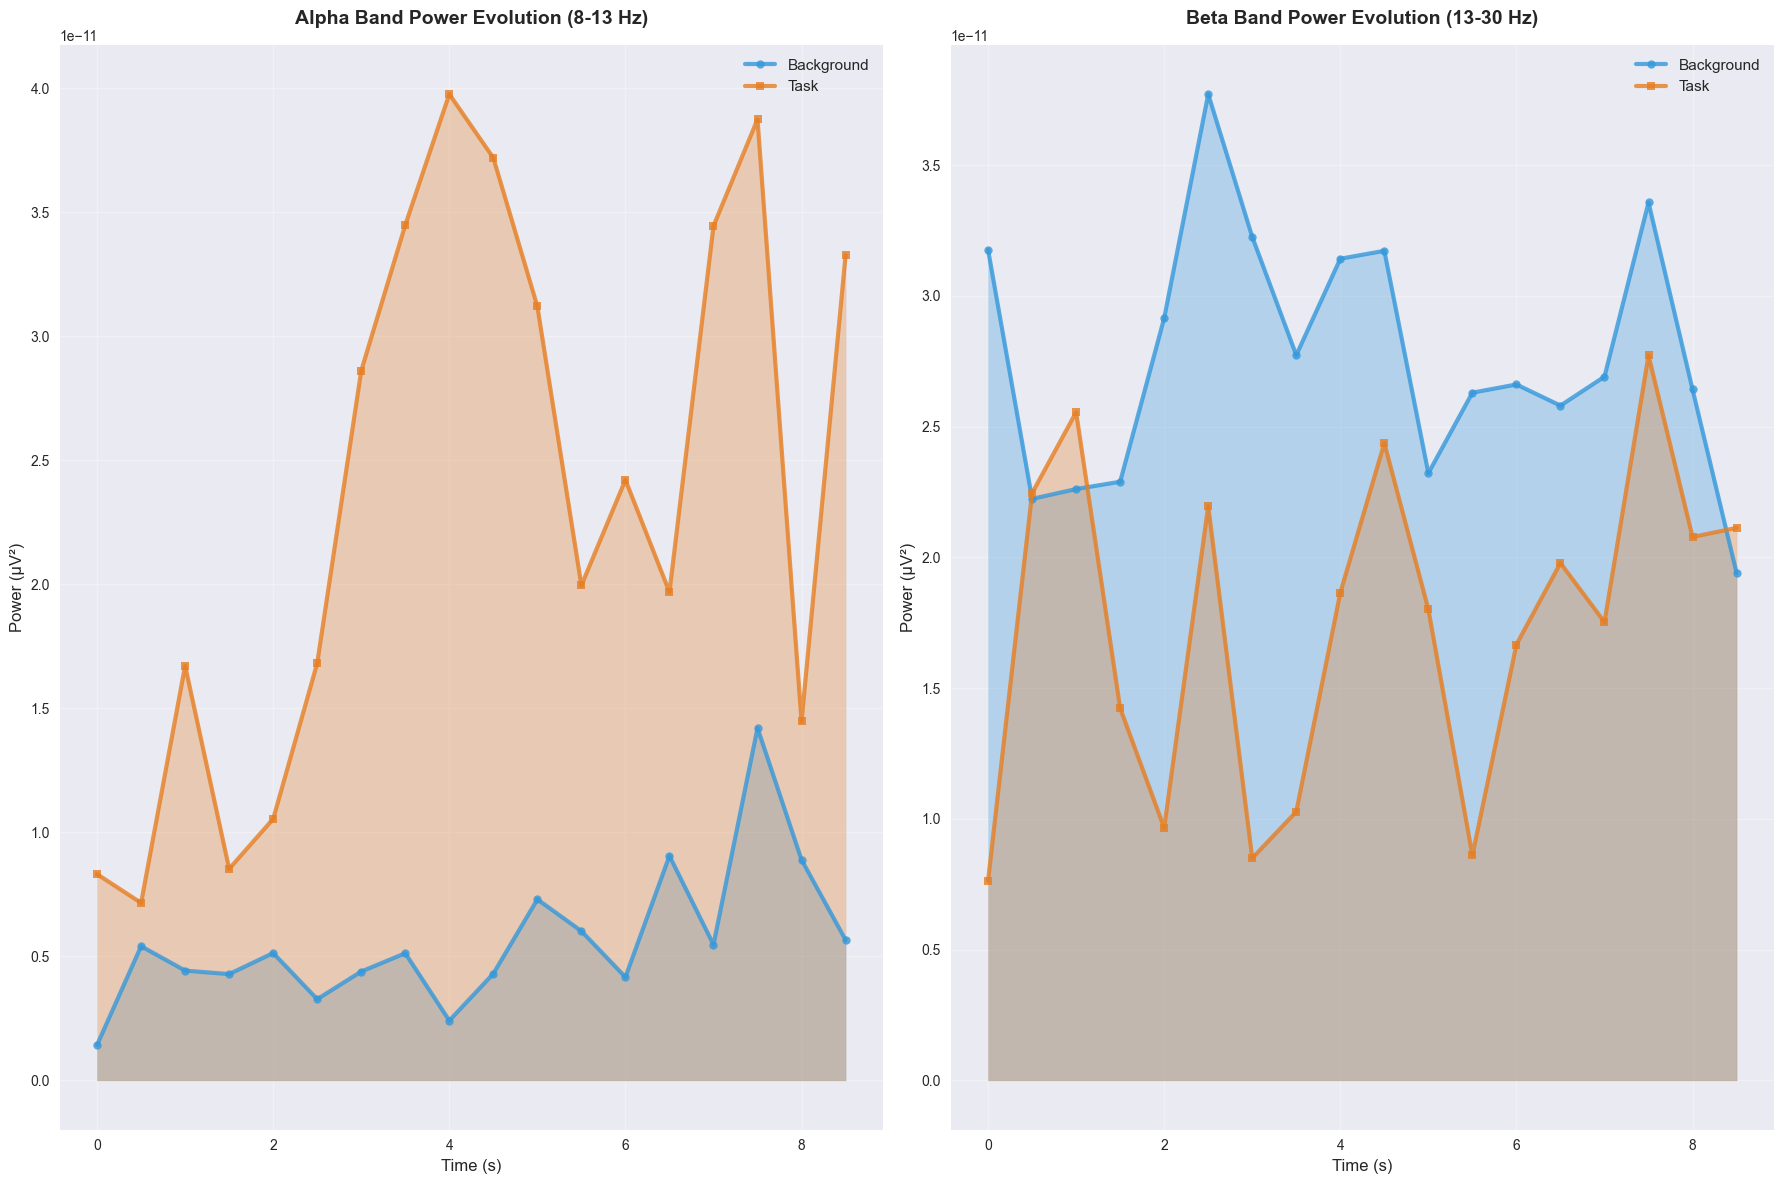

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data
train_data = pd.read_csv("eeg_train_data.csv")

# Channel to analyze
channel = "EEG C3"

# Sampling Frequency (after downsampling)
fs = 128

# Separate classes
background_data = train_data[train_data["Session"] == "Background"]
task_data = train_data[train_data["Session"] == "Task"]

# Enhanced plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# 1️⃣ Enhanced Time Series Plot
def plot_time_series_enhanced(subject, channel=channel, duration_sec=30):
    """Plot time series with better formatting and limited duration for clarity"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    subj_data = train_data[train_data["Subject"] == subject].copy()

    # Get background and task data
    bg_data = subj_data[subj_data["Session"] == "Background"]
    task_data = subj_data[subj_data["Session"] == "Task"]

    # Limit to first 30 seconds for better visualization
    max_samples = duration_sec * fs

    if len(bg_data) > 0:
        bg_subset = bg_data.head(min(max_samples, len(bg_data)))
        time_bg = np.arange(len(bg_subset)) / fs
        ax1.plot(time_bg, bg_subset[channel], color='#2E86C1', linewidth=0.8, alpha=0.8)
        ax1.set_title(f'Background Session - {channel} (Subject: {subject})', fontweight='bold')
        ax1.set_ylabel('Amplitude (µV)')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, duration_sec)

    if len(task_data) > 0:
        task_subset = task_data.head(min(max_samples, len(task_data)))
        time_task = np.arange(len(task_subset)) / fs
        ax2.plot(time_task, task_subset[channel], color='#E74C3C', linewidth=0.8, alpha=0.8)
        ax2.set_title(f'Task Session - {channel} (Subject: {subject})', fontweight='bold')
        ax2.set_ylabel('Amplitude (µV)')
        ax2.set_xlabel('Time (s)')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, duration_sec)

    plt.tight_layout()
    plt.show()

# Plot for Subject01
plot_time_series_enhanced("Subject01")

# 2️⃣ 3D Brain Activity Heatmap - EEG Channel Amplitude Distribution
from mpl_toolkits.mplot3d import Axes3D

# Define EEG electrode positions (10-20 system approximation)
electrode_positions = {
    'Fp1': (-0.3, 0.9), 'Fp2': (0.3, 0.9), 'F7': (-0.7, 0.4), 'F3': (-0.4, 0.4),
    'Fz': (0, 0.4), 'F4': (0.4, 0.4), 'F8': (0.7, 0.4), 'T3': (-0.9, 0),
    'C3': (-0.4, 0), 'Cz': (0, 0), 'C4': (0.4, 0), 'T4': (0.9, 0),
    'T5': (-0.7, -0.4), 'P3': (-0.4, -0.4), 'Pz': (0, -0.4), 'P4': (0.4, -0.4),
    'T6': (0.7, -0.4), 'O1': (-0.3, -0.8), 'O2': (0.3, -0.8)
}

fig = plt.figure(figsize=(18, 8))

# Background activity heatmap
ax1 = fig.add_subplot(121)
x_coords, y_coords, amplitudes_bg = [], [], []

for ch in eeg_channels:
    ch_name = ch.replace('EEG ', '')
    if ch_name in electrode_positions:
        x, y = electrode_positions[ch_name]
        amp = background_data[ch].mean()
        x_coords.append(x)
        y_coords.append(y)
        amplitudes_bg.append(amp)

# Create interpolated heatmap
from scipy.interpolate import griddata
xi = np.linspace(-1, 1, 100)
yi = np.linspace(-1, 1, 100)
XI, YI = np.meshgrid(xi, yi)
ZI_bg = griddata((x_coords, y_coords), amplitudes_bg, (XI, YI), method='cubic', fill_value=0)

# Create circular mask for brain shape
mask = (XI**2 + YI**2) <= 1
ZI_bg = np.where(mask, ZI_bg, np.nan)

im1 = ax1.contourf(XI, YI, ZI_bg, levels=20, cmap='Blues', alpha=0.8)
scatter1 = ax1.scatter(x_coords, y_coords, c=amplitudes_bg, s=100, cmap='Blues',
                       edgecolors='black', linewidth=2, zorder=5)

# Add electrode labels
for ch in eeg_channels:
    ch_name = ch.replace('EEG ', '')
    if ch_name in electrode_positions:
        x, y = electrode_positions[ch_name]
        ax1.annotate(ch_name, (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

ax1.set_title('Background Session - Brain Activity Heatmap', fontweight='bold', pad=20)
ax1.set_aspect('equal')
ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-1.2, 1.2)
ax1.axis('off')

# Task activity heatmap
ax2 = fig.add_subplot(122)
amplitudes_task = []

for ch in eeg_channels:
    ch_name = ch.replace('EEG ', '')
    if ch_name in electrode_positions:
        amp = task_data[ch].mean()
        amplitudes_task.append(amp)

ZI_task = griddata((x_coords, y_coords), amplitudes_task, (XI, YI), method='cubic', fill_value=0)
ZI_task = np.where(mask, ZI_task, np.nan)

im2 = ax2.contourf(XI, YI, ZI_task, levels=20, cmap='Oranges', alpha=0.8)
scatter2 = ax2.scatter(x_coords, y_coords, c=amplitudes_task, s=100, cmap='Oranges',
                       edgecolors='black', linewidth=2, zorder=5)

# Add electrode labels
for ch in eeg_channels:
    ch_name = ch.replace('EEG ', '')
    if ch_name in electrode_positions:
        x, y = electrode_positions[ch_name]
        ax2.annotate(ch_name, (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

ax2.set_title('Task Session - Brain Activity Heatmap', fontweight='bold', pad=20)
ax2.set_aspect('equal')
ax2.set_xlim(-1.2, 1.2)
ax2.set_ylim(-1.2, 1.2)
ax2.axis('off')

# Add colorbars
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8, pad=0.1)
cbar1.set_label('Amplitude (µV)', fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8, pad=0.1)
cbar2.set_label('Amplitude (µV)', fontweight='bold')

plt.tight_layout()
plt.show()

eeg_channels = [col for col in train_data.columns if col.startswith("EEG ")]
mean_background = background_data[channel].mean()
mean_task = task_data[channel].mean()


# 3️⃣ Enhanced Histogram with Statistics
fig, ax = plt.subplots(figsize=(12, 7))
bins = np.linspace(min(train_data[channel].min(), train_data[channel].min()),
                   max(train_data[channel].max(), train_data[channel].max()), 50)

ax.hist(background_data[channel].dropna(), bins=bins, alpha=0.7,
        label=f'Background (n={len(background_data)})', color='#3498DB', density=True)
ax.hist(task_data[channel].dropna(), bins=bins, alpha=0.7,
        label=f'Task (n={len(task_data)})', color='#E67E22', density=True)

# Add vertical lines for means
ax.axvline(mean_background, color='#2E86C1', linestyle='--', linewidth=2,
           label=f'Background Mean: {mean_background:.2f}')
ax.axvline(mean_task, color='#D35400', linestyle='--', linewidth=2,
           label=f'Task Mean: {mean_task:.2f}')

ax.set_title(f'Distribution of {channel} Amplitudes', fontweight='bold', pad=20)
ax.set_xlabel('Amplitude (µV)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4️⃣ Enhanced Power Spectral Density
fig, ax = plt.subplots(figsize=(12, 7))

def plot_psd_enhanced(signal, fs=128, label="", color='blue'):
    # Use more samples for better frequency resolution
    signal_clean = signal[~np.isnan(signal)]
    if len(signal_clean) > fs * 4:  # At least 4 seconds of data
        freqs, psd = welch(signal_clean, fs, nperseg=fs*2, noverlap=fs)
        ax.semilogy(freqs, psd, label=label, linewidth=2, color=color)

# Plot PSD for both conditions
bg_signal = background_data[channel].values
task_signal = task_data[channel].values

plot_psd_enhanced(bg_signal[:fs*20], fs=fs, label="Background", color='#3498DB')
plot_psd_enhanced(task_signal[:fs*20], fs=fs, label="Task", color='#E67E22')

# Add frequency band regions
alpha_band = (8, 13)
beta_band = (13, 30)
ax.axvspan(alpha_band[0], alpha_band[1], alpha=0.2, color='green', label='Alpha (8-13 Hz)')
ax.axvspan(beta_band[0], beta_band[1], alpha=0.2, color='red', label='Beta (13-30 Hz)')

ax.set_title(f'Power Spectral Density - {channel}', fontweight='bold', pad=20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (µV²/Hz)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 50)  # Focus on relevant frequency range
plt.tight_layout()
plt.show()

# 5️⃣ Enhanced FFT with Frequency Bands
fig, ax = plt.subplots(figsize=(12, 7))

def plot_fft_enhanced(signal, fs=128, label="", color='blue'):
    signal_clean = signal[~np.isnan(signal)]
    N = len(signal_clean)
    if N > fs:  # At least 1 second of data
        yf = fft(signal_clean)
        xf = fftfreq(N, 1 / fs)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[0:N // 2])
        ax.plot(xf[1:], magnitude[1:], label=label, linewidth=2, color=color)  # Skip DC component

plot_fft_enhanced(bg_signal[:fs*10], fs=fs, label="Background", color='#3498DB')
plot_fft_enhanced(task_signal[:fs*10], fs=fs, label="Task", color='#E67E22')

# Add frequency band regions
ax.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
ax.axvspan(13, 30, alpha=0.2, color='red', label='Beta (13-30 Hz)')

ax.set_title(f'Frequency Spectrum - {channel}', fontweight='bold', pad=20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 50)
plt.tight_layout()
plt.show()

# 6️⃣ Enhanced Band Power Analysis
def compute_band_power(signal, fs=128, band=(8, 13)):
    """Compute power in specific frequency band"""
    signal_clean = signal[~np.isnan(signal)]
    if len(signal_clean) < fs * 2:
        return 0

    freqs, psd = welch(signal_clean, fs=fs, nperseg=fs*2)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    band_power = np.trapz(psd[band_mask], freqs[band_mask])
    return band_power

# Calculate band powers
bands = {'Delta (1-4 Hz)': (1, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-13 Hz)': (8, 13), 'Beta (13-30 Hz)': (13, 30)}

bg_powers = []
task_powers = []
band_names = []

for band_name, band_range in bands.items():
    bg_power = compute_band_power(bg_signal, fs, band_range)
    task_power = compute_band_power(task_signal, fs, band_range)
    bg_powers.append(bg_power)
    task_powers.append(task_power)
    band_names.append(band_name)

# Plot band powers
x = np.arange(len(band_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, bg_powers, width, label='Background',
               color='#3498DB', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, task_powers, width, label='Task',
               color='#E67E22', alpha=0.8, edgecolor='black')

ax.set_title(f'Frequency Band Power Analysis - {channel}', fontweight='bold', pad=20)
ax.set_ylabel('Power (µV²)')
ax.set_xlabel('Frequency Bands')
ax.set_xticks(x)
ax.set_xticklabels(band_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2e}', ha='center', va='bottom', rotation=90, fontsize=9)

plt.tight_layout()
plt.show()

# 7️⃣ Enhanced Correlation Heatmap
eeg_channels = [col for col in train_data.columns if col.startswith("EEG")]
corr_matrix = train_data[eeg_channels].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
ax.set_title('EEG Channel Correlation Matrix', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 8️⃣ Enhanced Class Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
session_counts = train_data['Session'].value_counts()
bars = ax1.bar(session_counts.index, session_counts.values,
               color=['#3498DB', '#E67E22'], alpha=0.8, edgecolor='black')

for bar, count in zip(bars, session_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

ax1.set_title('Session Distribution (Count)', fontweight='bold')
ax1.set_ylabel('Number of Samples')
ax1.grid(True, alpha=0.3, axis='y')

# Pie chart
colors = ['#3498DB', '#E67E22']
wedges, texts, autotexts = ax2.pie(session_counts.values, labels=session_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90,
                                   textprops={'fontweight': 'bold'})
ax2.set_title('Session Distribution (Percentage)', fontweight='bold')

plt.tight_layout()
plt.show()

# 9️⃣ Dynamic Time-Frequency Spectrogram Analysis
from scipy.signal import spectrogram
import matplotlib.patches as patches

fig, ((ax3, ax4)) = plt.subplots(1, 2, figsize=(18, 12))

# Select a representative segment for analysis
segment_duration = 10  # seconds
segment_samples = segment_duration * fs

# Background spectrogram
bg_segment = background_data[channel].dropna().values[:segment_samples]
if len(bg_segment) >= segment_samples:
    frequencies, times, Sxx_bg = spectrogram(bg_segment, fs, nperseg=fs, noverlap=fs//2)

    # Plot spectrogram
    im1 = ax1.pcolormesh(times, frequencies, 10 * np.log10(Sxx_bg),
                         shading='gouraud', cmap='plasma', vmin=-40, vmax=10)
    ax1.set_title('Background Session - Time-Frequency Analysis', fontweight='bold', pad=15)
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylim(0, 50)

    # Add frequency band annotations
    alpha_patch = patches.Rectangle((0, 8), segment_duration, 5, linewidth=2,
                                   edgecolor='lime', facecolor='none', linestyle='--')
    beta_patch = patches.Rectangle((0, 13), segment_duration, 17, linewidth=2,
                                  edgecolor='cyan', facecolor='none', linestyle='--')
    ax1.add_patch(alpha_patch)
    ax1.add_patch(beta_patch)
    ax1.text(0.5, 10.5, 'Alpha', color='lime', fontweight='bold', fontsize=10)
    ax1.text(0.5, 21, 'Beta', color='cyan', fontweight='bold', fontsize=10)

    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Power (dB)', fontweight='bold')

# Task spectrogram
task_segment = task_data[channel].dropna().values[:segment_samples]
if len(task_segment) >= segment_samples:
    frequencies, times, Sxx_task = spectrogram(task_segment, fs, nperseg=fs, noverlap=fs//2)

    im2 = ax2.pcolormesh(times, frequencies, 10 * np.log10(Sxx_task),
                         shading='gouraud', cmap='plasma', vmin=-40, vmax=10)
    ax2.set_title('Task Session - Time-Frequency Analysis', fontweight='bold', pad=15)
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylim(0, 50)

    # Add frequency band annotations
    alpha_patch2 = patches.Rectangle((0, 8), segment_duration, 5, linewidth=2,
                                    edgecolor='lime', facecolor='none', linestyle='--')
    beta_patch2 = patches.Rectangle((0, 13), segment_duration, 17, linewidth=2,
                                   edgecolor='cyan', facecolor='none', linestyle='--')
    ax2.add_patch(alpha_patch2)
    ax2.add_patch(beta_patch2)
    ax2.text(0.5, 10.5, 'Alpha', color='lime', fontweight='bold', fontsize=10)
    ax2.text(0.5, 21, 'Beta', color='cyan', fontweight='bold', fontsize=10)

    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Power (dB)', fontweight='bold')

# Power evolution over time for key frequency bands
time_windows = np.arange(0, min(len(bg_segment), len(task_segment)) - fs, fs//2) / fs
alpha_power_bg, beta_power_bg = [], []
alpha_power_task, beta_power_task = [], []

for start_idx in range(0, min(len(bg_segment), len(task_segment)) - fs, fs//2):
    # Background
    window_bg = bg_segment[start_idx:start_idx + fs]
    freqs_bg, psd_bg = welch(window_bg, fs, nperseg=fs//2)
    alpha_mask = (freqs_bg >= 8) & (freqs_bg <= 13)
    beta_mask = (freqs_bg >= 13) & (freqs_bg <= 30)
    alpha_power_bg.append(np.trapz(psd_bg[alpha_mask], freqs_bg[alpha_mask]))
    beta_power_bg.append(np.trapz(psd_bg[beta_mask], freqs_bg[beta_mask]))

    # Task
    window_task = task_segment[start_idx:start_idx + fs]
    freqs_task, psd_task = welch(window_task, fs, nperseg=fs//2)
    alpha_power_task.append(np.trapz(psd_task[alpha_mask], freqs_task[alpha_mask]))
    beta_power_task.append(np.trapz(psd_task[beta_mask], freqs_task[beta_mask]))

# Plot alpha band evolution
ax3.plot(time_windows[:len(alpha_power_bg)], alpha_power_bg, 'o-',
         color='#3498DB', linewidth=3, markersize=6, label='Background', alpha=0.8)
ax3.plot(time_windows[:len(alpha_power_task)], alpha_power_task, 's-',
         color='#E67E22', linewidth=3, markersize=6, label='Task', alpha=0.8)
ax3.fill_between(time_windows[:len(alpha_power_bg)], alpha_power_bg, alpha=0.3, color='#3498DB')
ax3.fill_between(time_windows[:len(alpha_power_task)], alpha_power_task, alpha=0.3, color='#E67E22')
ax3.set_title('Alpha Band Power Evolution (8-13 Hz)', fontweight='bold', pad=15)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Power (µV²)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot beta band evolution
ax4.plot(time_windows[:len(beta_power_bg)], beta_power_bg, 'o-',
         color='#3498DB', linewidth=3, markersize=6, label='Background', alpha=0.8)
ax4.plot(time_windows[:len(beta_power_task)], beta_power_task, 's-',
         color='#E67E22', linewidth=3, markersize=6, label='Task', alpha=0.8)
ax4.fill_between(time_windows[:len(beta_power_bg)], beta_power_bg, alpha=0.3, color='#3498DB')
ax4.fill_between(time_windows[:len(beta_power_task)], beta_power_task, alpha=0.3, color='#E67E22')
ax4.set_title('Beta Band Power Evolution (13-30 Hz)', fontweight='bold', pad=15)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Power (µV²)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

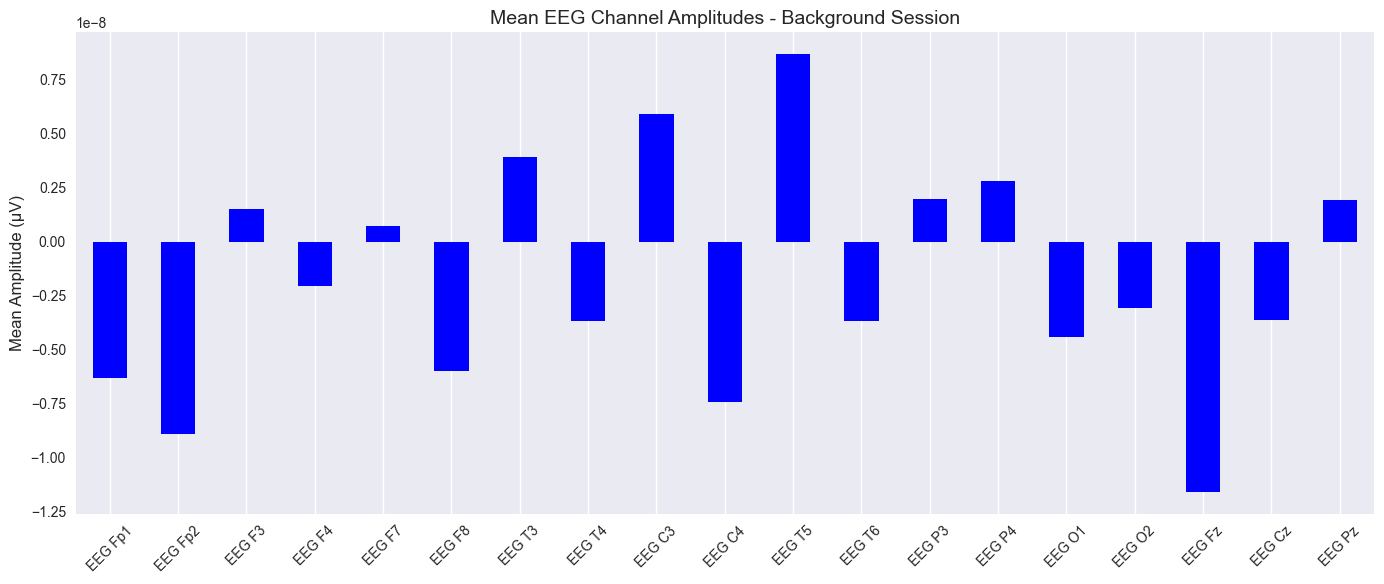

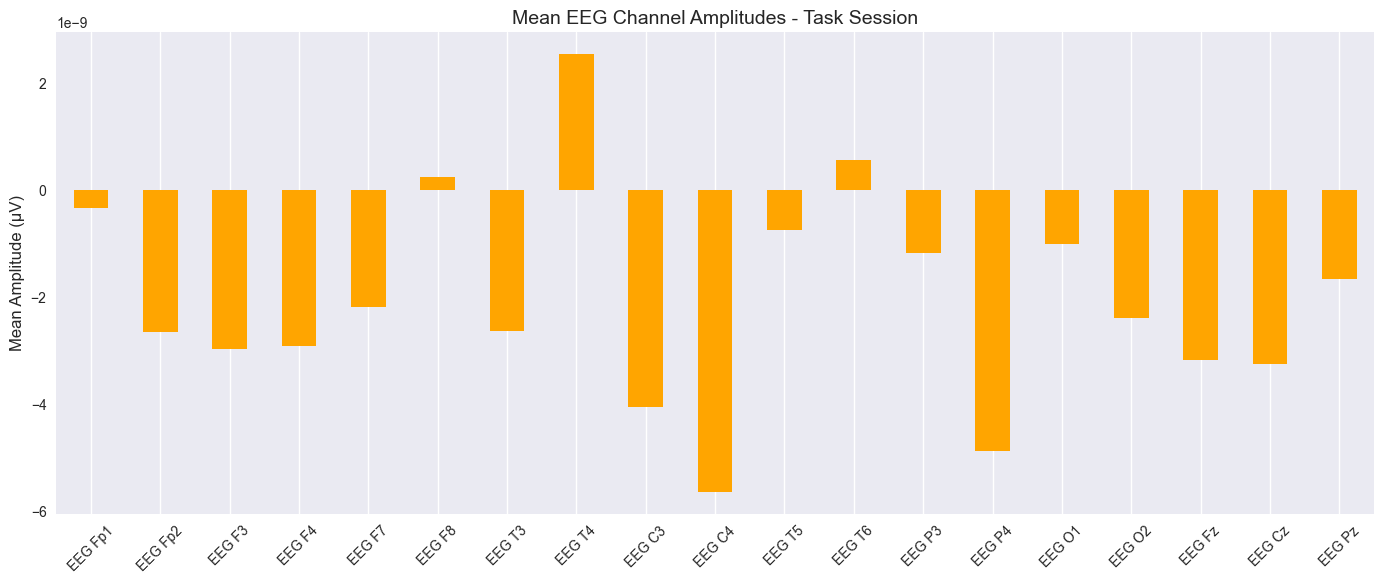

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data (adjust path as needed)
data = pd.read_csv("eeg_train_data.csv")

# List of EEG channels (excluding non-EEG cols)
eeg_channels = [
    'EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8',
    'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6',
    'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz'
]

# Calculate mean amplitude per EEG channel for Background and Task
mean_background = data[data["Session"] == "Background"][eeg_channels].mean()
mean_task = data[data["Session"] == "Task"][eeg_channels].mean()

# Plot 1: Background mean amplitudes
plt.figure(figsize=(14, 6))
mean_background.plot(kind='bar', color='blue')
plt.title("Mean EEG Channel Amplitudes - Background Session")
plt.ylabel("Mean Amplitude (µV)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Task mean amplitudes
plt.figure(figsize=(14, 6))
mean_task.plot(kind='bar', color='orange')
plt.title("Mean EEG Channel Amplitudes - Task Session")
plt.ylabel("Mean Amplitude (µV)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [24]:
# import numpy as np
# import pandas as pd
# import scipy.stats as stats
# from scipy.signal import welch
# from scipy.stats import entropy
# from tqdm.notebook import tqdm

# # === PARAMETERS ===
# fs = 128  # Sampling frequency in Hz
# window_sec = 2
# window_size = fs * window_sec

# eeg_channels = [
#     'EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8',
#     'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6',
#     'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz'
# ]

# freq_bands = {
#     "delta": (0.5, 4),
#     "theta": (4, 8),
#     "alpha": (8, 13),
#     "beta": (13, 30),
#     "gamma": (30, 45)
# }

# # === TIME DOMAIN FEATURES ===
# def extract_time_features(signal):
#     return {
#         "mean": np.mean(signal),
#         "std": np.std(signal),
#         "var": np.var(signal),
#         "skew": stats.skew(signal),
#         "kurtosis": stats.kurtosis(signal),
#         "zcr": ((signal[:-1] * signal[1:]) < 0).sum(),
#         "ptp": np.ptp(signal)
#     }

# # === FREQUENCY DOMAIN FEATURES ===
# def extract_freq_features(signal):
#     freqs, psd = welch(signal, fs=fs, nperseg=fs)
#     total_power = np.sum(psd)
#     psd_norm = psd / total_power if total_power > 0 else psd

#     band_power = {}
#     for band, (low, high) in freq_bands.items():
#         idx = np.logical_and(freqs >= low, freqs <= high)
#         power = np.sum(psd[idx])
#         rel_power = power / total_power if total_power > 0 else 0
#         band_power[f"{band}_power"] = power
#         band_power[f"{band}_rel_power"] = rel_power

#     spectral_entropy = entropy(psd_norm) if total_power > 0 else 0
#     spectral_centroid = np.sum(freqs * psd) / np.sum(psd) if total_power > 0 else 0
#     spectral_flatness = stats.gmean(psd + 1e-10) / (np.mean(psd) + 1e-10)
#     spectral_rolloff = freqs[np.where(np.cumsum(psd) >= 0.85 * total_power)[0][0]] if total_power > 0 else 0

#     band_power.update({
#         "spectral_entropy": spectral_entropy,
#         "spectral_centroid": spectral_centroid,
#         "spectral_flatness": spectral_flatness,
#         "spectral_rolloff": spectral_rolloff
#     })

#     return band_power

# # === FEATURE EXTRACTION FUNCTION ===
# def extract_features(df, is_train=True):
#     features = []

#     for subject in tqdm(df["Subject"].unique()):
#         subject_data = df[df["Subject"] == subject]

#         sessions = ["Background", "Task"] if is_train else [None]

#         for session in sessions:
#             if session:
#                 session_data = subject_data[subject_data["Session"] == session]
#             else:
#                 session_data = subject_data

#             for start in range(0, len(session_data) - window_size, window_size):
#                 window = session_data.iloc[start:start + window_size]
#                 feature_vector = {
#                     "Subject": subject,
#                 }
#                 if session:
#                     feature_vector["Session"] = session
#                 elif "Session" in window.columns:
#                     feature_vector["Session"] = window["Session"].iloc[0]

#                 for ch in eeg_channels:
#                     signal = window[ch].values
#                     time_feats = extract_time_features(signal)
#                     freq_feats = extract_freq_features(signal)

#                     for k, v in time_feats.items():
#                         feature_vector[f"{ch}_{k}"] = v
#                     for k, v in freq_feats.items():
#                         feature_vector[f"{ch}_{k}"] = v

#                 features.append(feature_vector)

#     return pd.DataFrame(features)

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import welch
from scipy.stats import entropy
from tqdm.notebook import tqdm

# === PARAMETERS ===
fs = 128  # Sampling frequency in Hz
window_sec = 2
window_size = fs * window_sec

eeg_channels = [
    'EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8',
    'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6',
    'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz'
]

freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

# === HJORTH PARAMETERS (Replaces Time Domain Features) ===
def extract_hjorth_parameters(signal):
    """
    Calculates the three Hjorth parameters: Activity, Mobility, and Complexity.
    """
    epsilon = 1e-9 # To prevent division by zero

    # Calculate variance of the signal
    var_signal = np.var(signal)
    
    # Calculate variance of the first derivative
    first_derivative = np.diff(signal)
    var_first_derivative = np.var(first_derivative)

    # Calculate variance of the second derivative
    second_derivative = np.diff(signal, n=2)
    var_second_derivative = np.var(second_derivative)

    # H0: Activity - The variance of the signal.
    activity = var_signal
    
    # H1: Mobility - The mean frequency or proportion of standard deviation.
    # sqrt(var(diff(signal)) / var(signal))
    mobility = np.sqrt(var_first_derivative / (var_signal + epsilon))
    
    # H2: Complexity - The change in frequency.
    # sqrt(var(diff(diff(signal))) / var(diff(signal))) / mobility
    mobility_of_first_derivative = np.sqrt(var_second_derivative / (var_first_derivative + epsilon))
    complexity = mobility_of_first_derivative / (mobility + epsilon)

    return {
        "hjorth_activity": activity,
        "hjorth_mobility": mobility,
        "hjorth_complexity": complexity
    }

# === FREQUENCY DOMAIN FEATURES (Unchanged) ===
def extract_freq_features(signal):
    freqs, psd = welch(signal, fs=fs, nperseg=fs)
    total_power = np.sum(psd)
    psd_norm = psd / total_power if total_power > 0 else psd

    band_power = {}
    for band, (low, high) in freq_bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        power = np.sum(psd[idx])
        rel_power = power / total_power if total_power > 0 else 0
        band_power[f"{band}_power"] = power
        band_power[f"{band}_rel_power"] = rel_power

    spectral_entropy = entropy(psd_norm) if total_power > 0 else 0
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd) if total_power > 0 else 0
    spectral_flatness = stats.gmean(psd + 1e-10) / (np.mean(psd) + 1e-10)
    
    # Handle potential empty slice for spectral_rolloff
    rolloff_idx = np.where(np.cumsum(psd) >= 0.85 * total_power)
    if rolloff_idx[0].size > 0:
        spectral_rolloff = freqs[rolloff_idx[0][0]]
    else:
        spectral_rolloff = 0 # Default if total_power is 0 or psd is empty

    band_power.update({
        "spectral_entropy": spectral_entropy,
        "spectral_centroid": spectral_centroid,
        "spectral_flatness": spectral_flatness,
        "spectral_rolloff": spectral_rolloff
    })

    return band_power

# === FEATURE EXTRACTION FUNCTION (Updated) ===
def extract_features(df, is_train=True):
    features = []

    for subject in tqdm(df["Subject"].unique()):
        subject_data = df[df["Subject"] == subject]

        sessions = ["Background", "Task"] if is_train else [None]

        for session in sessions:
            if session:
                session_data = subject_data[subject_data["Session"] == session]
            else:
                session_data = subject_data

            for start in range(0, len(session_data) - window_size, window_size):
                window = session_data.iloc[start:start + window_size]
                
                # Ensure window is full size (protects against last partial window)
                if len(window) < window_size:
                    continue

                feature_vector = {
                    "Subject": subject,
                }
                if session:
                    feature_vector["Session"] = session
                elif "Session" in window.columns:
                    feature_vector["Session"] = window["Session"].iloc[0]

                for ch in eeg_channels:
                    signal = window[ch].values
                    
                    # --- MODIFIED SECTION ---
                    # Call Hjorth parameter extraction
                    hjorth_feats = extract_hjorth_parameters(signal)
                    # --- END MODIFICATION ---
                    
                    freq_feats = extract_freq_features(signal)

                    # --- MODIFIED SECTION ---
                    # Add Hjorth features to the vector
                    for k, v in hjorth_feats.items():
                        feature_vector[f"{ch}_{k}"] = v
                    # --- END MODIFICATION ---
                        
                    for k, v in freq_feats.items():
                        feature_vector[f"{ch}_{k}"] = v

                features.append(feature_vector)

    return pd.DataFrame(features)

In [25]:
# === Load training or test EEG data ===
df_train = pd.read_csv("eeg_train_data.csv")
df_test = pd.read_csv("eeg_test_data.csv")

# === Extract features ===
train_features = extract_features(df_train, is_train=True)
test_features = extract_features(df_test, is_train=False)

# === Save to CSV (optional) ===
train_features.to_csv("eeg_train_features.csv", index=False)
test_features.to_csv("eeg_test_features.csv", index=False)


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
df_train.shape

(609824, 28)

In [27]:
train_features.shape

(2346, 325)

You have ~1 million rows.

Each feature vector is calculated over 256 rows (2 seconds).

So, total number of windows is approximately:

609824 / 256
≈
2346


In [28]:

train_features = pd.read_csv("eeg_train_features.csv")
test_features = pd.read_csv("eeg_test_features.csv")

print("📘 EEG Train Features Preview:")
display(train_features.head())

print("🧪 EEG Test Features Preview:")
display(test_features.head())


📘 EEG Train Features Preview:


,Subject,Session,EEG Fp1_hjorth_activity,EEG Fp1_hjorth_mobility,EEG Fp1_hjorth_complexity,EEG Fp1_delta_power,EEG Fp1_delta_rel_power,EEG Fp1_theta_power,EEG Fp1_theta_rel_power,EEG Fp1_alpha_power,...,EEG Pz_alpha_power,EEG Pz_alpha_rel_power,EEG Pz_beta_power,EEG Pz_beta_rel_power,EEG Pz_gamma_power,EEG Pz_gamma_rel_power,EEG Pz_spectral_entropy,EEG Pz_spectral_centroid,EEG Pz_spectral_flatness,EEG Pz_spectral_rolloff
0,Subject00,Background,7.157441e-11,0.380373,1.696301,4.040494e-12,0.058089,6.422666e-12,0.092337,5.762734e-12,...,2.059771e-11,0.147563,3.549489e-11,0.254288,4.652184e-11,0.333286,3.962628,32.410469,0.999901,55.0
1,Subject00,Background,6.645729e-11,0.377849,1.695920,3.010365e-12,0.046023,3.750483e-12,0.057338,4.586901e-12,...,9.289640e-12,0.083911,3.449224e-11,0.311560,2.724401e-11,0.246088,3.986447,31.907928,0.999950,51.0
2,Subject00,Background,7.223963e-11,0.369335,1.681077,7.047945e-12,0.089401,1.161057e-11,0.147277,3.271234e-12,...,1.852595e-11,0.114860,4.919121e-11,0.304984,3.639566e-11,0.225652,4.018102,33.297584,0.999916,56.0
3,Subject00,Background,6.178153e-11,0.355701,1.710708,4.719879e-12,0.074694,4.612964e-12,0.073002,5.630912e-12,...,1.172505e-11,0.099229,3.750910e-11,0.317438,2.959248e-11,0.250440,3.971616,33.224750,0.999933,55.0
4,Subject00,Background,6.721150e-11,0.368948,1.688454,3.198625e-12,0.045106,2.408936e-12,0.033970,6.972537e-12,...,8.008758e-12,0.072606,2.535800e-11,0.229891,2.819120e-11,0.255576,3.995910,32.137907,0.999951,55.0


🧪 EEG Test Features Preview:


,Subject,Session,EEG Fp1_hjorth_activity,EEG Fp1_hjorth_mobility,EEG Fp1_hjorth_complexity,EEG Fp1_delta_power,EEG Fp1_delta_rel_power,EEG Fp1_theta_power,EEG Fp1_theta_rel_power,EEG Fp1_alpha_power,...,EEG Pz_alpha_power,EEG Pz_alpha_rel_power,EEG Pz_beta_power,EEG Pz_beta_rel_power,EEG Pz_gamma_power,EEG Pz_gamma_rel_power,EEG Pz_spectral_entropy,EEG Pz_spectral_centroid,EEG Pz_spectral_flatness,EEG Pz_spectral_rolloff
0,Subject34,Background,6.371799e-11,0.346819,1.661460,2.642754e-12,0.041713,2.087734e-12,0.032953,6.717430e-12,...,1.853296e-11,0.105304,4.755460e-11,0.270204,4.142300e-11,0.235364,4.050984,33.248597,0.999914,55.0
1,Subject34,Background,6.998864e-11,0.361505,1.666064,7.602572e-12,0.109812,5.740640e-12,0.082918,6.216787e-12,...,1.739480e-11,0.087934,5.937872e-11,0.300170,5.096158e-11,0.257620,3.983466,33.856912,0.999838,57.0
2,Subject34,Background,6.353612e-11,0.331519,1.660215,6.728051e-12,0.099165,6.608136e-12,0.097397,5.914120e-12,...,8.887132e-12,0.055128,4.545135e-11,0.281939,4.434324e-11,0.275065,4.018259,31.145094,0.999909,53.0
3,Subject34,Background,7.047400e-11,0.338661,1.631645,5.901006e-12,0.093775,4.945553e-12,0.078591,5.508309e-12,...,2.043622e-11,0.128395,3.907166e-11,0.245476,4.055084e-11,0.254769,4.032465,33.722087,0.999917,57.0
4,Subject34,Background,5.735322e-11,0.321764,1.671627,2.834558e-12,0.055616,3.932411e-12,0.077156,5.172430e-12,...,1.725548e-11,0.108782,4.700675e-11,0.296339,4.387229e-11,0.276579,4.027619,32.435797,0.999915,54.0


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load features
df = pd.read_csv("eeg_train_features.csv")

# Encode target (Session: 'Background' or 'Task')
le = LabelEncoder()
df['Session_enc'] = le.fit_transform(df['Session'])  # Background=0, Task=1

# Drop non-feature cols
X = df.drop(columns=['Subject', 'Session', 'Session_enc'])
y = df['Session_enc']

# Scale features for models like LSTM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train test split for internal validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)


Train shape: (1876, 323) (1876,)
Validation shape: (470, 323) (470,)


In [30]:
import os
import sys
import time
import numpy as np
import pandas as pd
import warnings
from collections import Counter

# --- 1. Standard Library Imports (for Preprocessing & Metrics) ---
print("Loading standard utility libraries (sklearn, pandas, numpy)...")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# --- 2. Configuration (NEEDS YOUR INPUT) ---

# ❗ **ACTION REQUIRED**: Update this path to the folder containing your dataset folders.
# e.g., 'C:/Users/YourName/Desktop/My_Datasets'
DATASET_DIR = r'C:\Users\Research PC\Desktop\ML\EEG' 

# ❗ This script assumes your custom files are in this folder
CLASSIFIER_DIR = r'C:\Users\Research PC\Desktop\ML\Classifier_codes'

print(f"Importing your custom classifiers from '{CLASSIFIER_DIR}'...")
if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please make sure the path above is correct, using forward slashes (/) or r'...' for backslashes.")
    sys.exit(1)
# Add the absolute path to the system path
sys.path.append(os.path.abspath(CLASSIFIER_DIR))

try:
    # Adjust file and class names to match your files EXACTLY
    from KNN import KNN
    from LogisticRegression import LogisticRegression
    from DecisionTree import DecisionTreeClassifier # Assumes Node is in this file
    from RandomForest import RandomForestClassifier # Assumes it imports DT
    from SVM import LinearSVM
    from GaussianNaiveBayes import GaussianNaiveBayes
    from MultiLayerPerceptron import SimpleMLP
    from LinearDiscriminantAnalysis import LDA
    from AdaBoost import AdaBoost # Assumes it brings DecisionStump
    
    print("✅ Successfully imported all 9 custom classifiers.")
except ImportError as e:
    print(f"\n--- 🛑 IMPORT ERROR ---")
    print(f"Error importing custom classifiers: {e}")
    print("Please check the following:")
    print("1. File names in 'Classifier_codes' match the import (e.g., 'KNN.py').")
    print("2. Class names inside those files match the import (e.g., class KNN: ...)")
    print("3. 'RandomForest.py' and 'AdaBoost.py' correctly import their dependencies.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during import: {e}")
    sys.exit(1)


# --- 4. Helper: One-vs-Rest (OvR) Wrapper ---
class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None
        self.binary_le = None # For handling the binary-only case

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        if n_classes <= 2:
            self.binary_le = LabelEncoder() # Use 0/1
            y_binary = self.binary_le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            self.models[self.binary_le.classes_[1]] = model 
        else:
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if len(self.models) == 1 and self.binary_le:
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             return self.binary_le.inverse_transform(binary_preds)
        else:
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

# --- 5. Helper: Find Data Files ---
def find_data_files(folder_path):
    """Finds train/test files, prioritizing 'features' files."""
    files = [f.lower() for f in os.listdir(folder_path)]
    
    # Priority 1: Look for *features* files (like your eeg_train_features.csv)
    train_feat_file = next((f for f in files if "train_features.csv" in f), None)
    test_feat_file = next((f for f in files if "test_features.csv" in f), None)
    if train_feat_file and test_feat_file:
        print(f"Found pre-computed feature files: {train_feat_file}, {test_feat_file}")
        return os.path.join(folder_path, train_feat_file), os.path.join(folder_path, test_feat_file), "features"

    # Priority 2: Look for *data* files (like eeg_train_data.csv or train.csv)
    train_data_file = next((f for f in files if re.search(r'(train_data|train)\.csv', f)), None)
    test_data_file = next((f for f in files if re.search(r'(test_data|test)\.csv', f)), None)
    if train_data_file and test_data_file:
        print(f"Found raw data files: {train_data_file}, {test_data_file}")
        return os.path.join(folder_path, train_data_file), os.path.join(folder_path, test_data_file), "raw"

    # Priority 3: Look for a single CSV file to split
    csv_files = [f for f in files if f.endswith('.csv')]
    if len(csv_files) == 1:
        print(f"Found single data file: {csv_files[0]}. Will split 80/20.")
        return os.path.join(folder_path, csv_files[0]), None, "split"

    return None, None, None


# --- 6. Data Loading and Preprocessing Function ---
def load_and_preprocess_data(dataset_path):
    """Loads, cleans, and prepares data from the given folder."""
    print(f"--- Loading data from: {dataset_path} ---")
    train_file, test_file, mode = find_data_files(dataset_path)

    if mode is None:
        print(f"Error: No suitable CSV data files found in {dataset_path}.")
        return None
    
    try:
        # --- Load Data ---
        if mode == "split":
            df = pd.read_csv(train_file)
            target_col_name = df.columns[-1]
            df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, 
                                                 stratify=df[target_col_name].astype(str))
            print(f"Split {os.path.basename(train_file)} into train ({df_train.shape}) and test ({df_test.shape})")
        else:
            df_train = pd.read_csv(train_file)
            df_test = pd.read_csv(test_file)
            print(f"Loaded train ({df_train.shape}) and test ({df_test.shape})")

        # --- Identify Target ---
        # Assume target is 'Session' (from your EEG notebook) or the last column
        if 'Session' in df_train.columns:
            target_col = 'Session'
        elif 'Result' in df_train.columns: # From your heart attack notebook
            target_col = 'Result'
        else:
            target_col = df_train.columns[-1]
            print(f"Warning: Assuming last column '{target_col}' is the target variable.")

        # --- Preprocessing ---
        le = LabelEncoder()
        y_train = le.fit_transform(df_train[target_col])
        y_test = le.transform(df_test[target_col])
        n_classes = len(le.classes_)
        print(f"Target variable '{target_col}' encoded into {n_classes} classes: {list(le.classes_)}")

        # Drop 'Subject' (identifier) and target column
        drop_cols = [target_col, 'Subject', 'Unnamed: 0'] # Common identifiers/indices
        X_train_raw = df_train.drop(columns=drop_cols, errors='ignore')
        X_test_raw = df_test.drop(columns=drop_cols, errors='ignore')
        X_train_raw, X_test_raw = X_train_raw.align(X_test_raw, join='left', axis=1, fill_value=0)

        # --- Run Full Preprocessing *only if* raw data was loaded ---
        if mode == "raw" or mode == "split":
            print("Running full preprocessing pipeline (encoding, imputation)...")
            categorical_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns
            if not categorical_cols.empty:
                print(f"One-hot encoding categorical features: {list(categorical_cols)}")
                X_train_raw = pd.get_dummies(X_train_raw, columns=categorical_cols, drop_first=True)
                X_test_raw = pd.get_dummies(X_test_raw, columns=categorical_cols, drop_first=True)
                X_train_raw, X_test_raw = X_train_raw.align(X_test_raw, join='left', axis=1, fill_value=0)
        else:
            print("Skipping one-hot encoding (using pre-computed features).")

        # Always impute and scale
        print("Imputing missing values (mean strategy)...")
        imputer = SimpleImputer(strategy='mean')
        imputed_cols = X_train_raw.columns
        X_train_imputed = imputer.fit_transform(X_train_raw)
        X_test_imputed = imputer.transform(X_test_raw)

        # This is now the "unscaled" data for tree models
        X_train_unscaled = X_train_imputed
        X_test_unscaled = X_test_imputed

        print("Scaling features with StandardScaler...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_unscaled)
        X_test_scaled = scaler.transform(X_test_unscaled)
        
        return {
            "X_train_unscaled": X_train_unscaled, "y_train": y_train,
            "X_test_unscaled": X_test_unscaled, "y_test": y_test,
            "X_train_scaled": X_train_scaled, "X_test_scaled": X_test_scaled,
            "n_classes": n_classes, "n_features": X_train_unscaled.shape[1],
            "target_encoder": le
        }
    except Exception as e:
        import traceback
        print(f"Error processing data in {dataset_path}: {e}")
        traceback.print_exc()
        return None

# --- 7. Model Training and Benchmarking Function ---
def run_custom_models(data_dict):
    """Trains and evaluates ONLY the custom classifiers on the provided data."""
    X_train_unscaled = data_dict['X_train_unscaled']
    X_test_unscaled = data_dict['X_test_unscaled']
    X_train_scaled = data_dict['X_train_scaled']
    X_test_scaled = data_dict['X_test_scaled']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']
    n_features = data_dict['n_features']
    results = {}

    model_definitions = {
        # Models that need SCALED data
        "Custom_KNN": (KNN(k=5), X_train_scaled, X_test_scaled, y_train, y_test),
        "Custom_LDA": (LDA(), X_train_scaled, X_test_scaled, y_train, y_test),
        "Custom_LogReg_OvR": (OvRWrapper(LogisticRegression, learning_rate=0.01, n_iters=1000, verbose=False), X_train_scaled, X_test_scaled, y_train, y_test),
        "Custom_SVM_OvR": (OvRWrapper(LinearSVM, learning_rate=0.001, lambda_param=0.01, n_iters=1000, verbose=False), X_train_scaled, X_test_scaled, y_train, y_test),
        "Custom_MLP_OvR": (OvRWrapper(SimpleMLP, n_input=n_features, n_hidden=16, n_output=1, learning_rate=0.01, n_iters=1000, verbose=False, activation='relu'), X_train_scaled, X_test_scaled, y_train, y_test),
        
        # Models that prefer UNSCALED data
        "Custom_GNB": (GaussianNaiveBayes(), X_train_unscaled, X_test_unscaled, y_train, y_test),
        "Custom_DT": (DecisionTreeClassifier(max_depth=10, min_samples_split=3), X_train_unscaled, X_test_unscaled, y_train, y_test),
        "Custom_RF": (RandomForestClassifier(n_trees=20, max_depth=10, min_samples_split=3), X_train_unscaled, X_test_unscaled, y_train, y_test),
        "Custom_AdaBoost_OvR": (OvRWrapper(AdaBoost, n_estimators=20), X_train_unscaled, X_test_unscaled, y_train, y_test),
    }
    
    print("\n--- Running Your Custom Model Benchmarks ---")
    for name, (model, X_tr, X_te, y_tr, y_te) in model_definitions.items():
        try:
            print(f"  Training {name}...")
            start_time = time.time()
            model.fit(X_tr, y_tr) 
            print(f"  Predicting with {name}...")
            y_pred = model.predict(X_te)
            acc = accuracy_score(y_te, y_pred)
            duration = time.time() - start_time
            results[name] = acc
            print(f"  ✅ {name} Accuracy: {acc:<8.4f} (Time: {duration:.2f}s)")
        
        except Exception as e:
            import traceback
            print(f"  ❌ ERROR training/predicting with {name}: {e}")
            traceback.print_exc() 
            results[name] = 0.0
    
    return results

# --- 8. Main Execution ---
if __name__ == "__main__":

    # Find all dataset folders    
    dataset_name = os.path.basename(DATASET_DIR)
    print(f"\n\n{'='*25} Processing Dataset: {dataset_name} {'='*25}")
    
    # 1. Load and preprocess
    data = load_and_preprocess_data(DATASET_DIR)
    
    if data is not None:
        # 2. Run all models
        dataset_results = run_custom_models(data)
        
        # 3. Find and report the best model
        if dataset_results:
            sorted_results = sorted(dataset_results.items(), key=lambda item: item[1], reverse=True)
            
            print(f"\n--- 📊 Results for {dataset_name} (Best to Worst) ---")
            for model_name, accuracy in sorted_results:
                print(f"  {model_name:<20} | Accuracy: {accuracy:.4f}")
            
            best_model_name, best_accuracy = sorted_results[0]
            print(f"\n--- 🏆 Best Model for {dataset_name}: {best_model_name} ({best_accuracy:.4f}) ---")
        else:
            print(f"No results successfully generated for {dataset_name}.")
    else:
        print(f"Could not load or process data from {dataset_name}.")
        
    print(f"\n{'='*25} 🏁 Benchmark Complete 🏁 {'='*25}")

Loading standard utility libraries (sklearn, pandas, numpy)...
Importing your custom classifiers from 'C:\Users\Research PC\Desktop\ML\Classifier_codes'...
✅ Successfully imported all 9 custom classifiers.


========================= Processing Dataset: EEG =========================
--- Loading data from: C:\Users\Research PC\Desktop\ML\EEG ---
Found pre-computed feature files: eeg_train_features.csv, eeg_test_features.csv
Loaded train ((2346, 325)) and test ((140, 325))
Target variable 'Session' encoded into 2 classes: ['Background', 'Task']
Skipping one-hot encoding (using pre-computed features).
Imputing missing values (mean strategy)...
Scaling features with StandardScaler...

--- Running Your Custom Model Benchmarks ---
  Training Custom_KNN...
KNN fitted with 2346 samples.
  Predicting with Custom_KNN...
Predicting for 140 samples using KNN (k=5)...
  ✅ Custom_KNN Accuracy: 0.9857   (Time: 1.05s)
  Training Custom_LDA...
Fitting LDA...
LDA fitting complete.
  Predicting with Cust